# Simple Procedural Content Generation for Space Engineers

Create functional spaceships in Space Engineers by PCG using the [SE API](https://github.com/iv4xr-project/iv4xr-se-plugin).

Additional information for SE can be found [here](https://github.com/iv4xr-project/iv4xr-se-plugin/tree/main/JvmClient#basic-space-engineers-engine-info).

SE API calls are listed [here](https://github.com/iv4xr-project/iv4xr-se-plugin/blob/main/Source/Ivxr.SePlugin/Communication/AustinJsonRpcSpaceEngineers.cs).

**NOTE**: Have the game *running*; leaving the game simply paused breaks the API (no calls are accepted). *Suggestion*: Use windowed mode, press `Start` after the scenario is loaded and return to this notebook.

Import required packages

In [1]:
import ast
import json
import numpy as np
import random
import os
import socket
import time

from enum import Enum, auto
from typing import List, Optional, Dict, Any, Tuple

## API Interfacing

Variables for the API:

In [2]:
host = 'localhost'
port = 3333

API common structs/classes

In [3]:
def vec2(x: int,
         y: int) -> Dict[str, int]:
    return {
        "X": x,
        "Y": y
    }

def vec3(x: int,
         y: int,
         z: int) -> Dict[str, int]:
    return {
        "X": x,
        "Y": y,
        "Z": z
    }

def vec2f(x: float,
         y: float) -> Dict[str, float]:
    return {
        "X": x,
        "Y": y
    }

def vec3f(x: float,
         y: float,
         z: float) -> Dict[str, float]:
    return {
        "X": x,
        "Y": y,
        "Z": z
    }

def sum_vecs(a: Dict[str, Any],
             b: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "X": a["X"] + b["X"],
        "Y": a["Y"] + b["Y"],
        "Z": a["Z"] + b["Z"],
    }

def sum_tuples(a: Tuple[Any],
               b: Tuple[Any]) -> Tuple[Any]:
    assert len(a) == len(b), f'Can\'t sum tuples of different size ({len(a)} and {len(b)})'
    r = []
    for i in range(len(a)):
        r.append(type(a[i])(a[i] + b[i]))
    return tuple(r)

def to_list(a: Dict[str, Any]) -> Tuple[Any, Any, Any]:
    return (a["X"], a["Y"], a["Z"])

class Orientation(Enum):
    UP = vec3f(0., 1., 0.)
    DOWN = vec3f(0., -1., 0.)
    RIGHT = vec3f(1., 0., 0.)
    LEFT = vec3f(-1., 0., 0.)
    FORWARD = vec3f(0., 0., -1.)
    BACKWARD = vec3f(0., 0., 1.)

Character position to camera position offset

In [4]:
character_camera_dist = vec3f(0., 1.6369286, 0.)

### Block class

In [5]:
class Block:
    def __init__(self,
                 block_type: str,
                 orientation_forward: Orientation = Orientation.FORWARD,
                 orientation_up: Orientation = Orientation.UP):
        self.block_type = block_type
        self.orientation_forward = orientation_forward
        self.orientation_up = orientation_up
        self.position = vec3f(0., 0., 0.)
    
    def __str__(self) -> str:
        return f'{self.block_type} at {self.position}; OF {self.orientation_forward}; OU {self.orientation_up}'
    
    def __repr__(self) -> str:
        return f'{self.block_type} at {self.position}; OF {self.orientation_forward}; OU {self.orientation_up}'

blocks_dims = {
    's': 0.5,  # small
    'n': 1.,  # normal
    'l': 2.5  # large
}

def get_block_size(block: Block) -> str:
    return 's' if block.block_type.startswith('Small') else ('l'if block.block_type.startswith('Large') else 'n')

def get_block_dim(block: Block) -> float:
    return blocks_dims[get_block_size(block)]

### Structure class

A structure is a 3D matrix filled with `Block`s. Currently, the `Structure` is a fixed-size 3D matrix of smallest size cubes (`0.5`); larger cubes are inserted once and occupy the neighbouring spaces.

In [6]:
class Structure:
    def __init__(self,
                 origin: Dict[str, Any],
                 orientation_forward: Dict[str, Any],
                 orientation_up: Dict[str, Any],
                 dimensions: Tuple[int, int, int] = (10, 10, 10)) -> None:
        self._VALUE = 0.5
        self.origin_coords = origin
        self.orientation_forward = orientation_forward
        self.orientation_up = orientation_up
        self.dimensions = dimensions
        self._structure: np.ndarray = 0.5 * np.ones(dimensions)  # keeps track of occupied spaces
        self._blocks: Dict[float, Block] = {}  # keeps track of blocks info
            
    def add_block(self,
                  block: Block,
                  grid_position: Tuple[int, int, int]) -> None:
        k, j, i = grid_position
        assert self._structure[i][j][k] == 0.5, f'Error when attempting to place block {block.block_type}: space already occupied.'
        block_size = get_block_size(block)
        if block_size != 's':
            # update neighbouring cells
            r = 5 if block_size == 'l' else 2
            n, target = np.sum(self._structure[i:i+r, j:j+r, k:k+r]) - self._VALUE, self._VALUE * ((r ** 3) - 1)
            assert n == target, f'Error when placing block {block.block_type}: block would intersect already existing block(s).'
            self._structure[i:i+r, j:j+r, k:k+r] = np.zeros((r,r,r))
        block_id = float(self._VALUE + len(self._blocks.keys()) + 1)  # unique sequential block id as key in dict
        self._structure[i, j, k] = block_id
        self._blocks[block_id] = block
        # update block position
        dx, dy, dz = 0., 0., 0.
        if i > 0:
            for e in self._structure[0:i, j, k]:
                dz += get_block_dim(self._blocks[e]) if e > self._VALUE else e
        if j > 0:
            for e in self._structure[i, 0:j, k]:
                dy += get_block_dim(self._blocks[e]) if e > self._VALUE else e
        if k > 0:
            for e in self._structure[i, j, 0:k]:
                dx += get_block_dim(self._blocks[e]) if e > self._VALUE else e        
        block.position = sum_vecs(self.origin_coords, vec3f(dx, dy, dz))
    
    def get_all_blocks(self) -> List[Block]:
        return self._blocks.values()

### API interfacing methods

In [7]:
def generate_json(method: str,
                  params: Optional[List[Any]] = None) -> Dict[str, Any]:
    return {
        "jsonrpc": "2.0",
        "method": method,
        "params": params if params else [],
        "id": random.getrandbits(16)
    }

def compactify_jsons(jsons: List[Dict[str, Any]]) -> List[str]:
    """ JSONs should be single line & compact formatted before calling the API. (@Karel Hovorka)"""
    compacted_jsons = ''
    for j in jsons:
        compacted_jsons += json.dumps(obj=j,
                               separators=(',', ':'),
                               indent=None)
        compacted_jsons += '\r\n'

    return compacted_jsons

# Modified from https://www.binarytides.com/receive-full-data-with-the-recv-socket-function-in-python/
def recv_with_timeout(s: socket.socket,
                      timeout: int = 2):
    #make socket non blocking
    s.setblocking(0)
    #total data partwise in an array
    total_data = [];
    #beginning time
    begin = time.time()
    while True:
        # timeout termination
        if total_data and time.time() - begin > timeout:
            break
        # wait to get data
        elif time.time() - begin > timeout * 2:
            break
        # recv
        try:
            data = s.recv(8192).decode("utf-8")
            if data:
                # early break if socket returns the same data
                if len(total_data) > 1 and data == total_data[-1]:
                    break
                # append new data
                total_data.append(data)
                # change the beginning time for measurement
                begin = time.time()
            else:
                #sleep to indicate a gap
                time.sleep(0.1)
        except:
            # note: Exceptions are thrown due to socket not reading anything before and after data is passed
            pass
    # join all parts to make final string
    return ''.join(total_data)

def call_api(jsons: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    # open socket for communication
    s = socket.socket(family=socket.AF_INET,
                      type=socket.SOCK_STREAM)
    s.connect((host, port))    
    # send methods as compacted JSON bytearray
    s.sendall(compactify_jsons(jsons=jsons).encode('utf-8'))
    # get response
    res = recv_with_timeout(s)
    # close socket
    s.close()
    # due to TCP streming packets, it's possible some JSON-RPC responses are the same;
    # workaround: identify unique JSON-RPC responses by unique id
    return [json.loads(x) for x in list(set(res.strip().split('\r\n')))]

## Game speed

We can toggle the game speed by togglin the game's frame limit.

**NOTE**: Switch between `GameMode.PLACING` (fast) and `GameMode.EVALUATING` (slow).

In [8]:
class GameMode(Enum):
    PLACING = False
    EVALUATING = True

def toggle_gamemode(mode: GameMode) -> None:
    # "we plan to change the API and rename this function in near future" (@Karel Hovorka)
    call_api(jsons=[generate_json(method="Admin.SetFrameLimitEnabled",
                                  params=[mode.value])])

In [9]:
# toggle_gamemode(mode=GameMode.EVALUATING)

## Structure placement

[Blocks DefintionIDs](https://github.com/iv4xr-project/iv4xr-se-plugin/tree/main/JvmClient#definitionid-id) are used to specify which block to place. Here we either ask the API directly to provide us the list of available DefintionIDs or we can load the .JSON which contains them (faster in future runs).

**NOTE**: This cell produces the global variable `block_definitions`, a map between the block type and the API-supported ID to use in the request `params` field.

In [10]:
if not os.path.exists('./block_definitions.json'):
    # poll API for block definition ids
    jsons = [ 
        generate_json(method="Definitions.BlockDefinitions")
        ]
    res = json.loads(call_api(jsons=jsons))
    # transform to map of type:id
    block_definitions = {v['Type']:v for v in [entry['DefinitionId'] for entry in res['result']]}
    with open('./block_definitions.json', 'w') as f:
        json.dump(block_definitions, f)
else:
    with open('./block_definitions.json', 'r') as f:
        block_definitions = json.load(f)

Structure creation and placement.

In [11]:
def get_base_values():
    obs = call_api(jsons=[generate_json(method="Observer.Observe")])[0]
    base_position = obs['result']['Position']
    orientation_forward = obs['result']['OrientationForward']
    orientation_up = obs['result']['OrientationUp']
    return base_position, orientation_forward, orientation_up

def place_blocks(blocks: List[Block]) -> None:
    # prepare jsons
    jsons = [generate_json(method="Admin.Blocks.PlaceAt",
                           params={
                               "blockDefinitionId": block_definitions[block.block_type],
                               "position": block.position,
                               "orientationForward": block.orientation_forward.value,
                               "orientationUp": block.orientation_up.value
                           }) for block in blocks]
    # place blocks
    call_api(jsons=jsons)

Example of structure placement.

At the moment, the structure spawns but is not functional as the blocks are not part of the same game grid. Waiting to hear back from GoodAI.

In [12]:
# base_position, orientation_forward, orientation_up = get_base_values()
# structure = Structure(origin=base_position,
#                       orientation_forward=orientation_forward,
#                       orientation_up=orientation_up,
#                       dimensions=(10, 10, 10))
# structure.add_block(block=Block(block_type='LargeBlockSmallGenerator',
#                                 orientation_forward=Orientation.LEFT,
#                                 orientation_up=Orientation.DOWN),
#                     grid_position=(0, 0, 0)
#                     )
# structure.add_block(block=Block(block_type='LargeBlockCockpitSeat',
#                                 orientation_forward=Orientation.UP,
#                                 orientation_up=Orientation.RIGHT
#                                 ),
#                                 grid_position=(0, 5, 0))

# place_blocks(structure.get_all_blocks())

## Simple L-system

A simple L-system to generate a structure using rules.

Characters used in the expansion string:
- `B`/`b`: Small armor block
- `C`/`c`: Cockpit
- `E`/`e`: Engine
- `t`: Thruster
- `[` and `]`]: Push and pop current coordinate
- `+`: Move forward along `x`
- `-`: Move backward along `x`
- `!`: Move forward along `y`
- `?`: Move backward along `y`
- `>`: Move forward along `z`
- `<`: Move backward along `z`

In [13]:
alphabet = 'BbCcEet[]+-!?><'

### L Parser class.

Expansion and production methods transform the initial axiom using the provided rules for a number `n` of iterations.

**NOTE**: Rules can have multiple characters in the *RHS*, which allows for more complex axioms. Rules are stochastic (i.e.: $LHS \rightarrow p(RHS | LHS$); to make a rule deterministic simply use a single $LHS \rightarrow RHS$ with $p=1.$.

In [29]:
class StochasticRules:
    def __init__(self):
        self._rules = {}
    
    def add_rule(self,
                 lhs: str,
                 rhs: str,
                 p: float) -> None:
        if lhs in self._rules.keys():
            self._rules[lhs][0].append(rhs)
            self._rules[lhs][1].append(p)
        else:
            self._rules[lhs] = ([rhs], [p])
    
    def rem_rule(self,
                 lhs: str) -> None:
        self._rules.pop(lhs)
    
    def get_lhs(self) -> List[str]:
        return self._rules.keys()
    
    def get_rhs(self,
                lhs: str) -> str:
        rhs, p = self._rules[lhs]
        return np.random.choice(rhs, 1, p)[0]
    
    def validate(self):
        for lhs in self._rules.keys():
            p = sum(self._rules[lhs][1])
            assert p == 1., f'Probability must sum to 1: found {p} for `{lhs}`.'


class LParser:
    def __init__(self,
                 rules: StochasticRules):
        self.rules = rules

    def _expand(self,
                axiom: str) -> str:
        i = 0
        while i < len(axiom):
            for k in self.rules.get_lhs():
                if axiom[i:].startswith(k):
                    rhs = self.rules.get_rhs(k)
                    axiom = axiom[:i] + rhs + axiom[i + len(k):]
                    i += len(rhs) - 1  # since we use multiple characters in LHS, we need to skip them in the current iteration
                    break
            i += 1
        return axiom

    def produce(self,
                axiom: str,
                n: int) -> str:
        for _ in range(n):
            axiom = self._expand(axiom=axiom)
        return axiom

### Solver class

The `Solver` can both solve for a given axiom and fill a `Structure` with an axiom.

Mapping axiom atoms to `Structure` interactions:

In [15]:
class AtomAction(Enum):
    PLACE = auto()
    MOVE = auto()
    PUSH = auto()
    POP = auto()

# this is a temporary example, as orientations are predefined instead of being assigned in the axiom
atoms_alphabet = {
    'B': {'action': AtomAction.PLACE,
          'args': ('SmallBlockArmorBlock', Orientation.FORWARD, Orientation.UP)},
    'b': {'action': AtomAction.PLACE,
          'args': ('SmallBlockArmorBlock', Orientation.FORWARD, Orientation.UP)},
    'C': {'action': AtomAction.PLACE,
          'args': ('LargeBlockCockpitSeat', Orientation.UP, Orientation.RIGHT)},
    'c': {'action': AtomAction.PLACE,
          'args': ('LargeBlockCockpitSeat', Orientation.UP, Orientation.RIGHT)},
    'E': {'action': AtomAction.PLACE,
          'args': ('LargeBlockSmallGenerator', Orientation.LEFT, Orientation.DOWN)},
    'e': {'action': AtomAction.PLACE,
          'args': ('LargeBlockSmallGenerator', Orientation.LEFT, Orientation.DOWN)},
    
    '+': {'action': AtomAction.MOVE,
          'args': Orientation.RIGHT.value},
    '-': {'action': AtomAction.MOVE,
          'args': Orientation.LEFT.value},
    '!': {'action': AtomAction.MOVE,
          'args': Orientation.UP.value},
    '?': {'action': AtomAction.MOVE,
          'args': Orientation.DOWN.value},
    '>': {'action': AtomAction.MOVE,
          'args': Orientation.FORWARD.value},
    '<': {'action': AtomAction.MOVE,
          'args': Orientation.BACKWARD.value},
    
    '[': {'action': AtomAction.PUSH,
          'args': []},
    ']': {'action': AtomAction.POP,
          'args': []}
}

In [16]:
class LSolver:
    def __init__(self,
                 atoms_alphabet: Dict[str, Dict[AtomAction, Any]],
                 parser: LParser):
        self.atoms_alphabet = atoms_alphabet
        self.parser = parser
    
    def solve(self,
              axiom: str,
              iterations: int) -> str:
        return self.parser.produce(axiom=axiom,
                                   n=iterations)
    
    def fill_structure(self,
                       structure: Structure,
                       axiom: str) -> None:
        position_history = []  # used as stack (LIFO)
        position = (0, 0, 0)
        for a in axiom:
            action, args = self.atoms_alphabet[a]['action'], self.atoms_alphabet[a]['args']
            if action == AtomAction.PLACE:
                structure.add_block(block=Block(args[0], args[1], args[2]),
                                    grid_position=position)
            elif action == AtomAction.MOVE:
                position = sum_tuples(position, to_list(args))
            elif action == AtomAction.PUSH:
                position_history.append(position)
            elif action == AtomAction.POP:
                position = position_history.pop()
            if max(position) > min(structure.dimensions):
                print('Unable to fully fill structure.')
                break

### Rule maker

Read a configuration file with the rules and create the Rule object.

In [37]:
class RuleMaker:
    def __init__(self,
                 ruleset: str):
        with open(ruleset, 'r') as f:
            self.ruleset = f.readlines()
    
    def get_rules(self) -> StochasticRules:
        rules = StochasticRules()
        for rule in self.ruleset:
            if rule.startswith('#'):  # comment in configuration file
                pass
            else:
                lhs, p, rhs = rule.strip().split(' ')
            rules.add_rule(lhs=lhs,
                           rhs=rhs,
                           p=float(p))
        rules.validate()
        return rules

## L-System demo

Populate different structures with L-system solutions at different iterations.

Result:

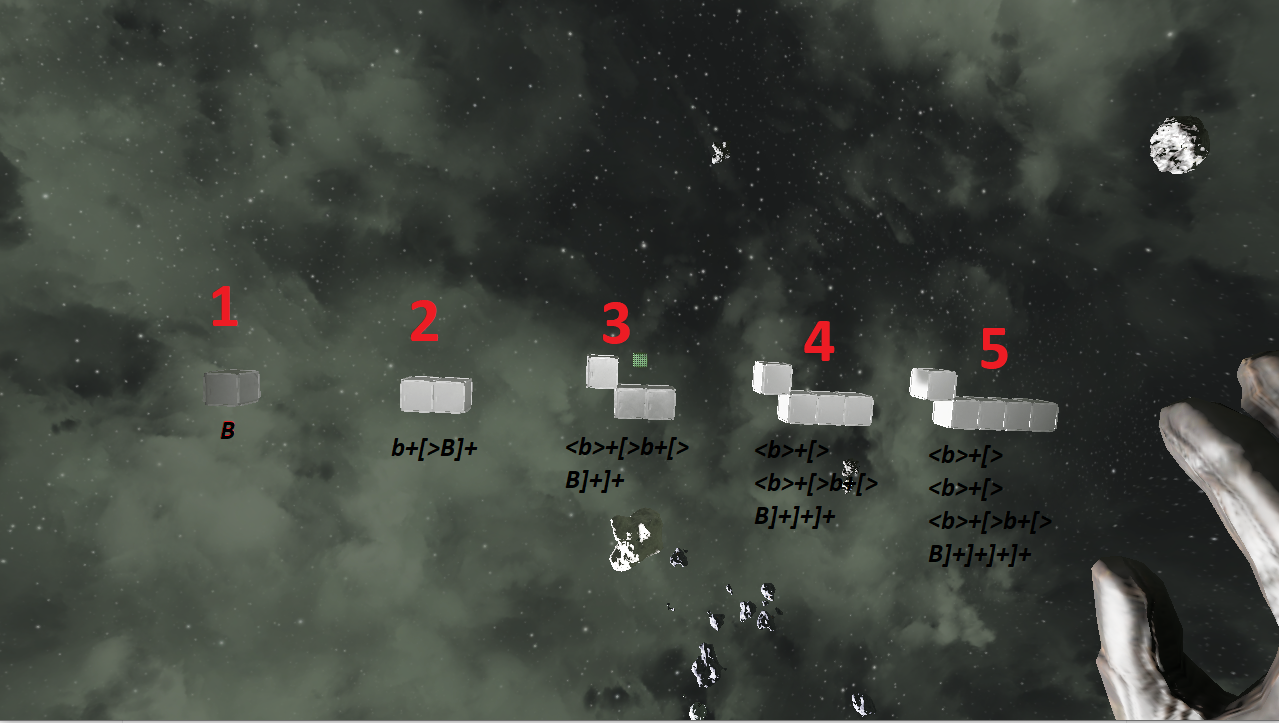

In [42]:
rules = RuleMaker(ruleset='rules').get_rules()

parser = LParser(rules=rules)

solver = LSolver(atoms_alphabet=atoms_alphabet,
                 parser=parser)

In [43]:
base_position, orientation_forward, orientation_up = get_base_values()

for i in range(5):
    print(f'Iteration {i}...')
    origin_position = sum_vecs(base_position, vec3f(i*3, 0., 0.))
    
    structure = Structure(origin=origin_position,
                          orientation_forward=orientation_forward,
                          orientation_up=orientation_up,
                          dimensions=(5, 5, 5))
    
    axiom = solver.solve('B', i)
    
    print(f'\t-> Axiom: {axiom}')
    
    solver.fill_structure(structure=structure,
                          axiom=axiom)
    
    blocks = structure.get_all_blocks()
        
    place_blocks(blocks)

Iteration 0...
	-> Axiom: B
Iteration 1...
	-> Axiom: b+[>B]+
Iteration 2...
	-> Axiom: <b>+[>b+[>B]+]+
Iteration 3...
	-> Axiom: <b!!b??>+[><b!!b??>+[>b+[>B]+]+]+
Iteration 4...
	-> Axiom: <b!!b??>+[><b>+[><b>+[>b+[>B]+]+]+]+
